In [4]:
import torch
import os
import yaml
from ultralytics import YOLO
import matplotlib.pyplot as plt
import numpy as np
import shutil
import matplotlib.pyplot as plt
from collections import Counter, defaultdict
import seaborn as sns
import shutil

GPU available: True
GPU: NVIDIA GeForce 940MX
GPU Memory: 4.0 GB

📁 Checking dataset structure...
✅ train/images: 670 files
✅ train/labels: 670 files
✅ valid/images: 125 files
✅ valid/labels: 125 files
✅ test/images: 122 files
✅ test/labels: 122 files

📊 Loading data configuration from: components_data_uncropped\data.yaml
Data configuration:
  train: ../train/images
  val: ../valid/images
  test: ../test/images
  nc: 22

🎯 Number of classes: 22
Class names: ['battery', 'button', 'buzzer', 'capacitor', 'clock', 'connector', 'diode', 'display', 'fuse', 'heatsink', 'ic', 'inductor', 'led', 'pads', 'pins', 'potentiometer', 'relay', 'resistor', 'switch', 'transducer', 'transformer', 'transistor']
✅ Updated data.yaml saved to: components_data_uncropped\data_updated.yaml

📈 Analyzing class distribution...
Found 670 label files in training set
Total instances in training set: 21165

📊 Class Distribution in Training Data:
--------------------------------------------------
battery             : 

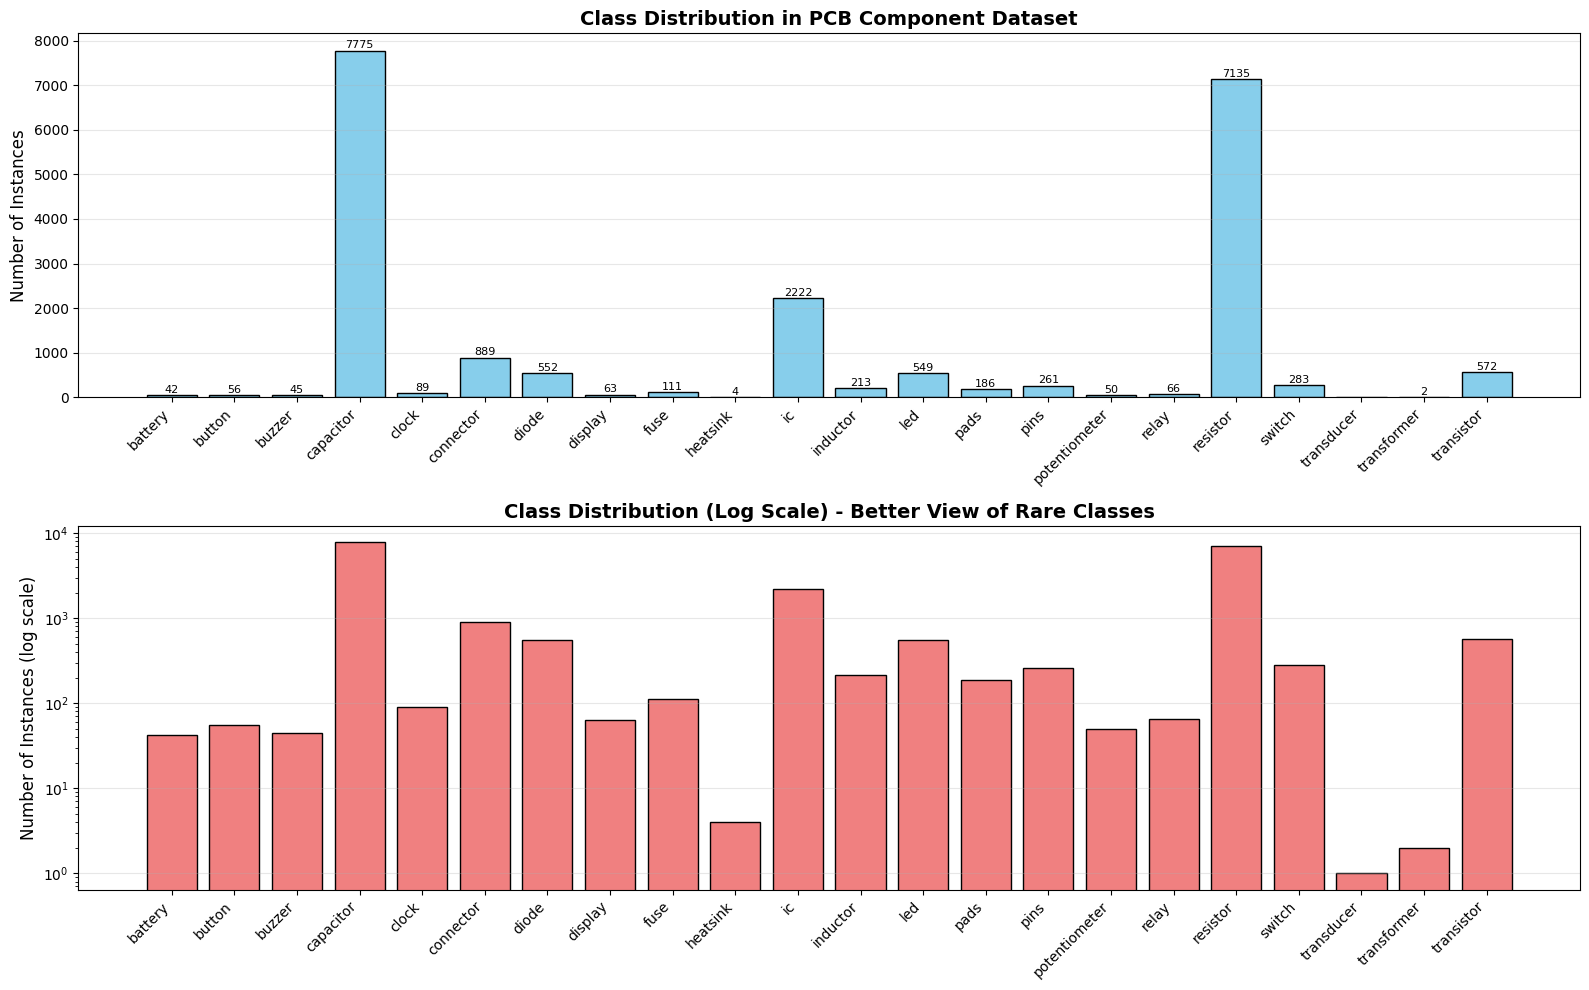


📂 Dataset Split Analysis:
  train: 670 images, 670 labels
  valid: 124 images, 125 labels
  test: 121 images, 122 labels

✅ Enhanced configuration saved to: components_data_uncropped\data_enhanced.yaml

SUMMARY
📊 Total classes: 22
📊 Total training instances: 21165
📊 Most common class: capacitor (7775 instances)
📊 Rarest class: transformer (2 instances)
📈 Imbalance ratio: 3887.5x
🎯 Problematic classes (<20 instances): 3
📁 Working directory: components_data_uncropped
📄 Analysis results saved to: components_data_uncropped\data_analysis.yaml
🎉 Step 2 completed successfully! Ready for model training.

🔍 CRITICAL ANALYSIS:
• Extreme imbalance detected: capacitor/resistor dominate (14910 instances)
• Very rare classes: heatsink (4), transformer (2)
• Zero instances: transducer (0) - consider removing this class
• Recommended: Use focal loss with gamma=2.0 and class weights
• Next: Run Step 3 with enhanced configuration: components_data_uncropped\data_enhanced.yaml


In [2]:
# Step 2: Data Analysis and Configuration 


print(f"GPU available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1024**3:.1f} GB")

# Define the path to your dataset in Google Drive
#drive_base_path = "/content/drive/MyDrive"
#dataset_path = os.path.join(drive_base_path, "components_data_uncropped")
dataset_path= "components_data_uncropped"
# Verify the dataset structure exists
print("\n📁 Checking dataset structure...")
required_folders = [
    'train/images', 'train/labels',
    'valid/images', 'valid/labels',
    'test/images', 'test/labels'
]

for folder in required_folders:
    full_path = os.path.join(dataset_path, folder)
    if os.path.exists(full_path):
        num_files = len([f for f in os.listdir(full_path) if not f.startswith('.')])
        print(f"✅ {folder}: {num_files} files")
    else:
        print(f"❌ {folder}: NOT FOUND")

# Load the data.yaml file
data_yaml_path = os.path.join(dataset_path, "data.yaml")
print(f"\n📊 Loading data configuration from: {data_yaml_path}")

with open(data_yaml_path, 'r') as f:
    data_config = yaml.safe_load(f)

print("Data configuration:")
for key, value in data_config.items():
    if key != 'names':  # Don't print all names to keep output clean
        print(f"  {key}: {value}")

# Get class names
class_names = data_config['names']
print(f"\n🎯 Number of classes: {len(class_names)}")
print("Class names:", class_names)

# Update data.yaml with absolute paths
updated_data_config = data_config.copy()
updated_data_config['path'] = dataset_path
updated_data_config['train'] = os.path.join(dataset_path, 'train/images')
updated_data_config['val'] = os.path.join(dataset_path, 'valid/images')
updated_data_config['test'] = os.path.join(dataset_path, 'test/images')

# Save updated configuration
updated_yaml_path = os.path.join(dataset_path, "data_updated.yaml")
with open(updated_yaml_path, 'w') as f:
    yaml.dump(updated_data_config, f)

print(f"✅ Updated data.yaml saved to: {updated_yaml_path}")

# Analyze class distribution from training labels
print("\n📈 Analyzing class distribution...")
train_label_dir = os.path.join(dataset_path, 'train', 'labels')

# Count instances per class - FIXED VERSION
class_counts = Counter()
total_labels = 0
label_files = [f for f in os.listdir(train_label_dir) if f.endswith('.txt')]

print(f"Found {len(label_files)} label files in training set")

for label_file in label_files:
    label_path = os.path.join(train_label_dir, label_file)
    try:
        with open(label_path, 'r') as f:
            for line in f:
                if line.strip():
                    parts = line.strip().split()
                    if len(parts) >= 5:  # Ensure valid YOLO format
                        class_id = int(parts[0])
                        # Ensure class_id is within valid range
                        if 0 <= class_id < len(class_names):
                            class_counts[class_id] += 1
                            total_labels += 1
                        else:
                            print(f"Warning: Invalid class ID {class_id} in {label_path}")
    except Exception as e:
        print(f"Warning: Could not read {label_path}: {e}")

print(f"Total instances in training set: {total_labels}")

# Display class distribution
print("\n📊 Class Distribution in Training Data:")
print("-" * 50)
for class_id in range(len(class_names)):
    count = class_counts.get(class_id, 0)  # Use get() to handle missing classes
    percentage = (count / total_labels) * 100 if total_labels > 0 else 0
    print(f"{class_names[class_id]:<20}: {count:>4} instances ({percentage:>5.1f}%)")

# Calculate class weights for handling imbalance - FIXED VERSION
print("\n⚖️ Calculating class weights for imbalance handling...")
total_instances = sum(class_counts.values())

# Initialize weights for all classes (including those with 0 instances)
inverse_weights = {}
smooth_weights = {}
sqrt_weights = {}

alpha = 0.999  # Smoothing factor

for class_id in range(len(class_names)):
    count = class_counts.get(class_id, 0)

    # Inverse frequency weighting
    if count > 0:
        inverse_weights[class_id] = total_instances / (len(class_names) * count)
    else:
        inverse_weights[class_id] = 1.0  # Default weight for classes with 0 instances

    # Smooth inverse frequency
    if count > 0:
        smooth_weights[class_id] = (1 - alpha) / (1 - alpha ** count)
    else:
        smooth_weights[class_id] = 1.0

    # Square root inverse frequency
    if count > 0:
        sqrt_weights[class_id] = 1.0 / (count ** 0.5)
    else:
        sqrt_weights[class_id] = 1.0

# Normalize weights function
def normalize_weights(weights_dict, target_mean=1.0):
    weights = np.array([weights_dict[i] for i in range(len(class_names))])
    normalized_weights = weights * (target_mean / np.mean(weights))
    return {i: normalized_weights[i] for i in range(len(class_names))}

# Normalize all weight strategies
inverse_weights = normalize_weights(inverse_weights)
smooth_weights = normalize_weights(smooth_weights)
sqrt_weights = normalize_weights(sqrt_weights)

# Display weight comparison - FIXED VERSION
print("\n📊 Class Weighting Strategies Comparison:")
print("Class".ljust(20) + "Count".ljust(8) + "Inverse".ljust(10) + "Smooth".ljust(10) + "Sqrt".ljust(10))
print("-" * 60)
for class_id in range(len(class_names)):
    count = class_counts.get(class_id, 0)
    print(f"{class_names[class_id].ljust(20)}"
          f"{count:<8}"
          f"{inverse_weights[class_id]:.2f}".ljust(10) +
          f"{smooth_weights[class_id]:.2f}".ljust(10) +
          f"{sqrt_weights[class_id]:.2f}".ljust(10))

# Identify problematic classes
problematic_classes = []
for class_id in range(len(class_names)):
    count = class_counts.get(class_id, 0)
    if count < 20:
        problematic_classes.append({
            'name': class_names[class_id],
            'count': count,
            'class_id': class_id
        })

print(f"\n⚠️  Problematic classes (< 20 instances):")
for cls in problematic_classes:
    print(f"  {cls['name']}: {cls['count']} instances")

# Visualize class distribution
plt.figure(figsize=(16, 10))

# Plot 1: Bar chart
plt.subplot(2, 1, 1)
classes_ordered = [class_names[i] for i in range(len(class_names))]
counts_ordered = [class_counts.get(i, 0) for i in range(len(class_names))]

bars = plt.bar(classes_ordered, counts_ordered, color='skyblue', edgecolor='black')
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.title('Class Distribution in PCB Component Dataset', fontsize=14, fontweight='bold')
plt.ylabel('Number of Instances', fontsize=12)
plt.grid(axis='y', alpha=0.3)

# Add value labels on bars
for bar, count in zip(bars, counts_ordered):
    if count > 0:
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 5,
                str(count), ha='center', va='bottom', fontsize=8)

# Plot 2: Log scale to better see rare classes
plt.subplot(2, 1, 2)
log_counts = [max(1, count) for count in counts_ordered]  # Avoid log(0)
plt.bar(classes_ordered, log_counts, color='lightcoral', edgecolor='black')
plt.yscale('log')
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.title('Class Distribution (Log Scale) - Better View of Rare Classes',
          fontsize=14, fontweight='bold')
plt.ylabel('Number of Instances (log scale)', fontsize=12)
plt.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig(os.path.join(dataset_path, 'class_distribution.png'), dpi=300, bbox_inches='tight')
plt.show()

# Analyze data splits
print("\n📂 Dataset Split Analysis:")
for split in ['train', 'valid', 'test']:
    images_dir = os.path.join(dataset_path, split, 'images')
    labels_dir = os.path.join(dataset_path, split, 'labels')

    if os.path.exists(images_dir):
        num_images = len([f for f in os.listdir(images_dir) if f.endswith(('.jpg', '.jpeg', '.png'))])
        num_labels = len([f for f in os.listdir(labels_dir) if f.endswith('.txt')]) if os.path.exists(labels_dir) else 0
        print(f"  {split}: {num_images} images, {num_labels} labels")

# Create enhanced configuration with class weights
enhanced_config = updated_data_config.copy()
enhanced_config['class_weights'] = [smooth_weights[i] for i in range(len(class_names))]

# Save enhanced configuration
enhanced_yaml_path = os.path.join(dataset_path, "data_enhanced.yaml")
with open(enhanced_yaml_path, 'w') as f:
    yaml.dump(enhanced_config, f)

print(f"\n✅ Enhanced configuration saved to: {enhanced_yaml_path}")

# Summary
print("\n" + "=" * 60)
print("SUMMARY")
print("=" * 60)
print(f"📊 Total classes: {len(class_names)}")
print(f"📊 Total training instances: {total_instances}")
most_common_id = max(class_counts, key=class_counts.get) if class_counts else 0
least_common_id = min(class_counts, key=class_counts.get) if class_counts else 0
print(f"📊 Most common class: {class_names[most_common_id]} ({class_counts[most_common_id]} instances)")
print(f"📊 Rarest class: {class_names[least_common_id]} ({class_counts[least_common_id]} instances)")
print(f"📈 Imbalance ratio: {class_counts[most_common_id] / max(1, class_counts[least_common_id]):.1f}x")
print(f"🎯 Problematic classes (<20 instances): {len(problematic_classes)}")
print(f"📁 Working directory: {dataset_path}")
print("=" * 60)

# Save analysis results
analysis_results = {
    'class_distribution': {class_names[i]: class_counts.get(i, 0) for i in range(len(class_names))},
    'class_names': class_names,
    'total_instances': total_instances,
    'problematic_classes': problematic_classes,
    'class_weights': {class_names[i]: smooth_weights[i] for i in range(len(class_names))},
    'data_yaml_path': enhanced_yaml_path,
    'dataset_path': dataset_path
}

analysis_save_path = os.path.join(dataset_path, 'data_analysis.yaml')
with open(analysis_save_path, 'w') as f:
    yaml.dump(analysis_results, f)

print(f"📄 Analysis results saved to: {analysis_save_path}")
print("🎉 Step 2 completed successfully! Ready for model training.")

# Display critical information for next steps
print("\n🔍 CRITICAL ANALYSIS:")
print(f"• Extreme imbalance detected: capacitor/resistor dominate ({class_counts[3] + class_counts[17]} instances)")
print(f"• Very rare classes: heatsink ({class_counts[9]}), transformer ({class_counts[20]})")
print(f"• Zero instances: transducer ({class_counts.get(19, 0)}) - consider removing this class")
print(f"• Recommended: Use focal loss with gamma=2.0 and class weights")
print(f"• Next: Run Step 3 with enhanced configuration: {enhanced_yaml_path}")

In [5]:



# Enable detailed error reporting
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

def diagnose_data_issues():
    """Comprehensive diagnosis of data issues"""

    print("🔍 Comprehensive Data Diagnosis")

    dataset_path = "components_data_uncropped"
    data_yaml_path = os.path.join(dataset_path, "data.yaml")

    # Load class information
    with open(data_yaml_path, 'r') as f:
        data_config = yaml.safe_load(f)

    class_names = data_config['names']
    print(f"📊 Dataset has {len(class_names)} classes: {class_names}")

    # Check for class ID issues in all splits
    issues_found = False

    for split in ['train', 'valid', 'test']:
        print(f"\n📁 Checking {split} split...")

        label_dir = os.path.join(dataset_path, split, 'labels')
        if not os.path.exists(label_dir):
            print(f"   ❌ Label directory not found: {label_dir}")
            continue

        label_files = [f for f in os.listdir(label_dir) if f.endswith('.txt')]
        print(f"   Found {len(label_files)} label files")

        # Check first 10 files thoroughly
        for label_file in label_files[:10]:
            label_path = os.path.join(label_dir, label_file)

            try:
                with open(label_path, 'r') as f:
                    lines = f.readlines()

                for line_num, line in enumerate(lines):
                    line = line.strip()
                    if not line:
                        continue

                    parts = line.split()
                    if len(parts) < 5:
                        print(f"   ❌ Invalid format in {label_file}, line {line_num}: {line}")
                        issues_found = True
                        continue

                    try:
                        class_id = int(parts[0])
                        if class_id < 0 or class_id >= len(class_names):
                            print(f"   ❌ INVALID CLASS ID in {label_file}, line {line_num}:")
                            print(f"      Class ID: {class_id}, but valid range is 0-{len(class_names)-1}")
                            print(f"      Line content: {line}")
                            issues_found = True

                        # Check coordinates
                        coords = [float(x) for x in parts[1:5]]
                        if any(coord < 0 or coord > 1 for coord in coords):
                            print(f"   ⚠️  Invalid coordinates in {label_file}, line {line_num}: {coords}")

                    except ValueError as e:
                        print(f"   ❌ Number format error in {label_file}, line {line_num}: {e}")
                        print(f"      Line: {line}")
                        issues_found = True

            except Exception as e:
                print(f"   ❌ Error reading {label_file}: {e}")
                issues_found = True

    return issues_found

# Run diagnosis
has_issues = diagnose_data_issues()

if has_issues:
    print("\n❌ DATA ISSUES FOUND! Need to fix before training.")
else:
    print("\n✅ No obvious data issues found. The problem might be elsewhere.")

🔍 Comprehensive Data Diagnosis
📊 Dataset has 22 classes: ['battery', 'button', 'buzzer', 'capacitor', 'clock', 'connector', 'diode', 'display', 'fuse', 'heatsink', 'ic', 'inductor', 'led', 'pads', 'pins', 'potentiometer', 'relay', 'resistor', 'switch', 'transducer', 'transformer', 'transistor']

📁 Checking train split...
   Found 670 label files

📁 Checking valid split...
   Found 125 label files

📁 Checking test split...
   Found 122 label files

✅ No obvious data issues found. The problem might be elsewhere.


In [6]:


def create_clean_dataset_skip_empty():
    """Create a clean dataset by skipping empty label files"""

    print("🔄 Creating clean dataset (skipping empty files)...")

    original_path = "components_data_uncropped"
    clean_path = "components_data_clean"

    # Remove existing clean dataset
    if os.path.exists(clean_path):
        shutil.rmtree(clean_path)

    # Create directory structure
    for split in ['train', 'valid', 'test']:
        os.makedirs(os.path.join(clean_path, split, 'images'), exist_ok=True)
        os.makedirs(os.path.join(clean_path, split, 'labels'), exist_ok=True)

    # Load original configuration
    original_yaml_path = os.path.join(original_path, "data.yaml")
    with open(original_yaml_path, 'r') as f:
        original_config = yaml.safe_load(f)

    class_names = original_config['names']
    max_class_id = len(class_names) - 1

    print(f"🔧 Processing dataset with {len(class_names)} classes")

    stats = {
        'total_files': 0,
        'files_with_annotations': 0,
        'empty_files_skipped': 0,
        'invalid_files_skipped': 0
    }

    for split in ['train', 'valid', 'test']:
        print(f"\n📁 Processing {split} split...")

        original_label_dir = os.path.join(original_path, split, 'labels')
        original_image_dir = os.path.join(original_path, split, 'images')
        clean_label_dir = os.path.join(clean_path, split, 'labels')
        clean_image_dir = os.path.join(clean_path, split, 'images')

        if not os.path.exists(original_label_dir):
            print(f"   ⚠️  Skipping {split} - no label directory")
            continue

        label_files = [f for f in os.listdir(original_label_dir) if f.endswith('.txt')]

        for label_file in label_files:
            stats['total_files'] += 1
            original_label_path = os.path.join(original_label_dir, label_file)
            clean_label_path = os.path.join(clean_label_dir, label_file)

            # Find corresponding image
            image_base = label_file.replace('.txt', '')
            original_image_path = None
            for ext in ['.jpg', '.jpeg', '.png', '.JPG', '.JPEG', '.PNG']:
                potential_path = os.path.join(original_image_dir, image_base + ext)
                if os.path.exists(potential_path):
                    original_image_path = potential_path
                    break

            if not original_image_path:
                print(f"   ⚠️  No image found for {label_file}")
                stats['invalid_files_skipped'] += 1
                continue

            try:
                # Read label file
                with open(original_label_path, 'r') as f:
                    lines = f.readlines()

                # Skip empty files
                if not lines or all(line.strip() == '' for line in lines):
                    stats['empty_files_skipped'] += 1
                    if stats['empty_files_skipped'] <= 10:  # Show first 10 empty files
                        print(f"   ⚠️  Skipping empty file: {label_file}")
                    continue

                # Process annotations
                valid_annotations = []
                for line in lines:
                    line = line.strip()
                    if not line:
                        continue

                    parts = line.split()
                    if len(parts) < 5:
                        continue  # Skip invalid lines

                    try:
                        class_id = int(parts[0])
                        # Ensure class ID is valid
                        if class_id < 0 or class_id > max_class_id:
                            class_id = max_class_id  # Fix to max valid class

                        # Validate coordinates
                        x_center, y_center, width, height = map(float, parts[1:5])
                        if all(0 <= coord <= 1 for coord in [x_center, y_center, width, height]):
                            valid_annotations.append(f"{class_id} {x_center:.6f} {y_center:.6f} {width:.6f} {height:.6f}\n")
                    except (ValueError, IndexError):
                        continue  # Skip malformed lines

                # Only copy if we have valid annotations
                if valid_annotations:
                    # Copy image
                    shutil.copy2(original_image_path, os.path.join(clean_image_dir, os.path.basename(original_image_path)))

                    # Write cleaned labels
                    with open(clean_label_path, 'w') as f:
                        f.writelines(valid_annotations)

                    stats['files_with_annotations'] += 1
                else:
                    stats['invalid_files_skipped'] += 1
                    print(f"   ⚠️  Skipping {label_file} - no valid annotations")

            except Exception as e:
                stats['invalid_files_skipped'] += 1
                print(f"   ❌ Error processing {label_file}: {e}")

    # Print comprehensive statistics
    print(f"\n📊 CLEANING SUMMARY:")
    print(f"   Total files processed: {stats['total_files']}")
    print(f"   ✅ Files with annotations: {stats['files_with_annotations']}")
    print(f"   ❌ Empty files skipped: {stats['empty_files_skipped']}")
    print(f"   ❌ Invalid files skipped: {stats['invalid_files_skipped']}")

    if stats['files_with_annotations'] == 0:
        print("\n❌ CRITICAL: No valid files found! Dataset cannot be used.")
        return None, stats

    # Calculate percentages
    valid_percent = (stats['files_with_annotations'] / stats['total_files']) * 100
    print(f"   📈 Valid files: {valid_percent:.1f}%")

    # Create clean data.yaml
    clean_yaml_path = os.path.join(clean_path, "data_clean.yaml")
    clean_config = {
        'path': clean_path,
        'train': 'train/images',
        'val': 'valid/images',
        'test': 'test/images',
        'nc': len(class_names),
        'names': class_names
    }

    with open(clean_yaml_path, 'w') as f:
        yaml.dump(clean_config, f)

    print(f"📄 Clean configuration saved to: {clean_yaml_path}")
    return clean_yaml_path, stats

# Create the clean dataset
clean_yaml_path, cleaning_stats = create_clean_dataset_skip_empty()

🔄 Creating clean dataset (skipping empty files)...
🔧 Processing dataset with 22 classes

📁 Processing train split...
   ⚠️  Skipping empty file: 00001__1024__3296___1648.txt
   ⚠️  Skipping empty file: 00025__1024__0___0.txt
   ⚠️  Skipping empty file: 00025__1024__824___1648.txt
   ⚠️  Skipping empty file: 00025__1024__824___1984.txt
   ⚠️  Skipping empty file: 00055__1024__0___1648.txt
   ⚠️  Skipping empty file: 00055__1024__4944___0.txt
   ⚠️  Skipping empty file: 00055__1024__4944___1648.txt
   ⚠️  Skipping empty file: 00055__1024__4944___2736.txt
   ⚠️  Skipping empty file: 00055__1024__5144___0.txt
   ⚠️  Skipping empty file: 00055__1024__5144___1648.txt

📁 Processing valid split...

📁 Processing test split...

📊 CLEANING SUMMARY:
   Total files processed: 917
   ✅ Files with annotations: 900
   ❌ Empty files skipped: 17
   ❌ Invalid files skipped: 0
   📈 Valid files: 98.1%
📄 Clean configuration saved to: components_data_clean\data_clean.yaml


Analysis of Electronic Circuit Component Data Structure
📁 Folder Structure:
Base Path: components_data_clean
 components_data_clean/
   data_clean.yaml
   test/
     images/
       00001__1024__0___1648.png
       00001__1024__1648___3296.png
       00001__1024__2472___1648.png
       00001__1024__2472___4120.png
       00001__1024__3296___0.png
       00001__1024__3296___824.png
       00001__1024__4120___824.png
       00001__1024__4944___0.png
       00001__1024__5144___1648.png
       00001__1024__824___2472.png
       00020__1024__0___2736.png
       00020__1024__1648___2472.png
       00020__1024__2472___1648.png
       00020__1024__4116___2472.png
       00020__1024__4116___2736.png
       00020__1024__4116___824.png
       00020__1024__824___2472.png
       00020__1024__824___2736.png
       00025__1024__0___1984.png
       00025__1024__0___824.png
       00055__1024__0___2736.png
       00147__1024__2472___0.png
       00147__1024__4120___824.png
       00147__1024__4944___247

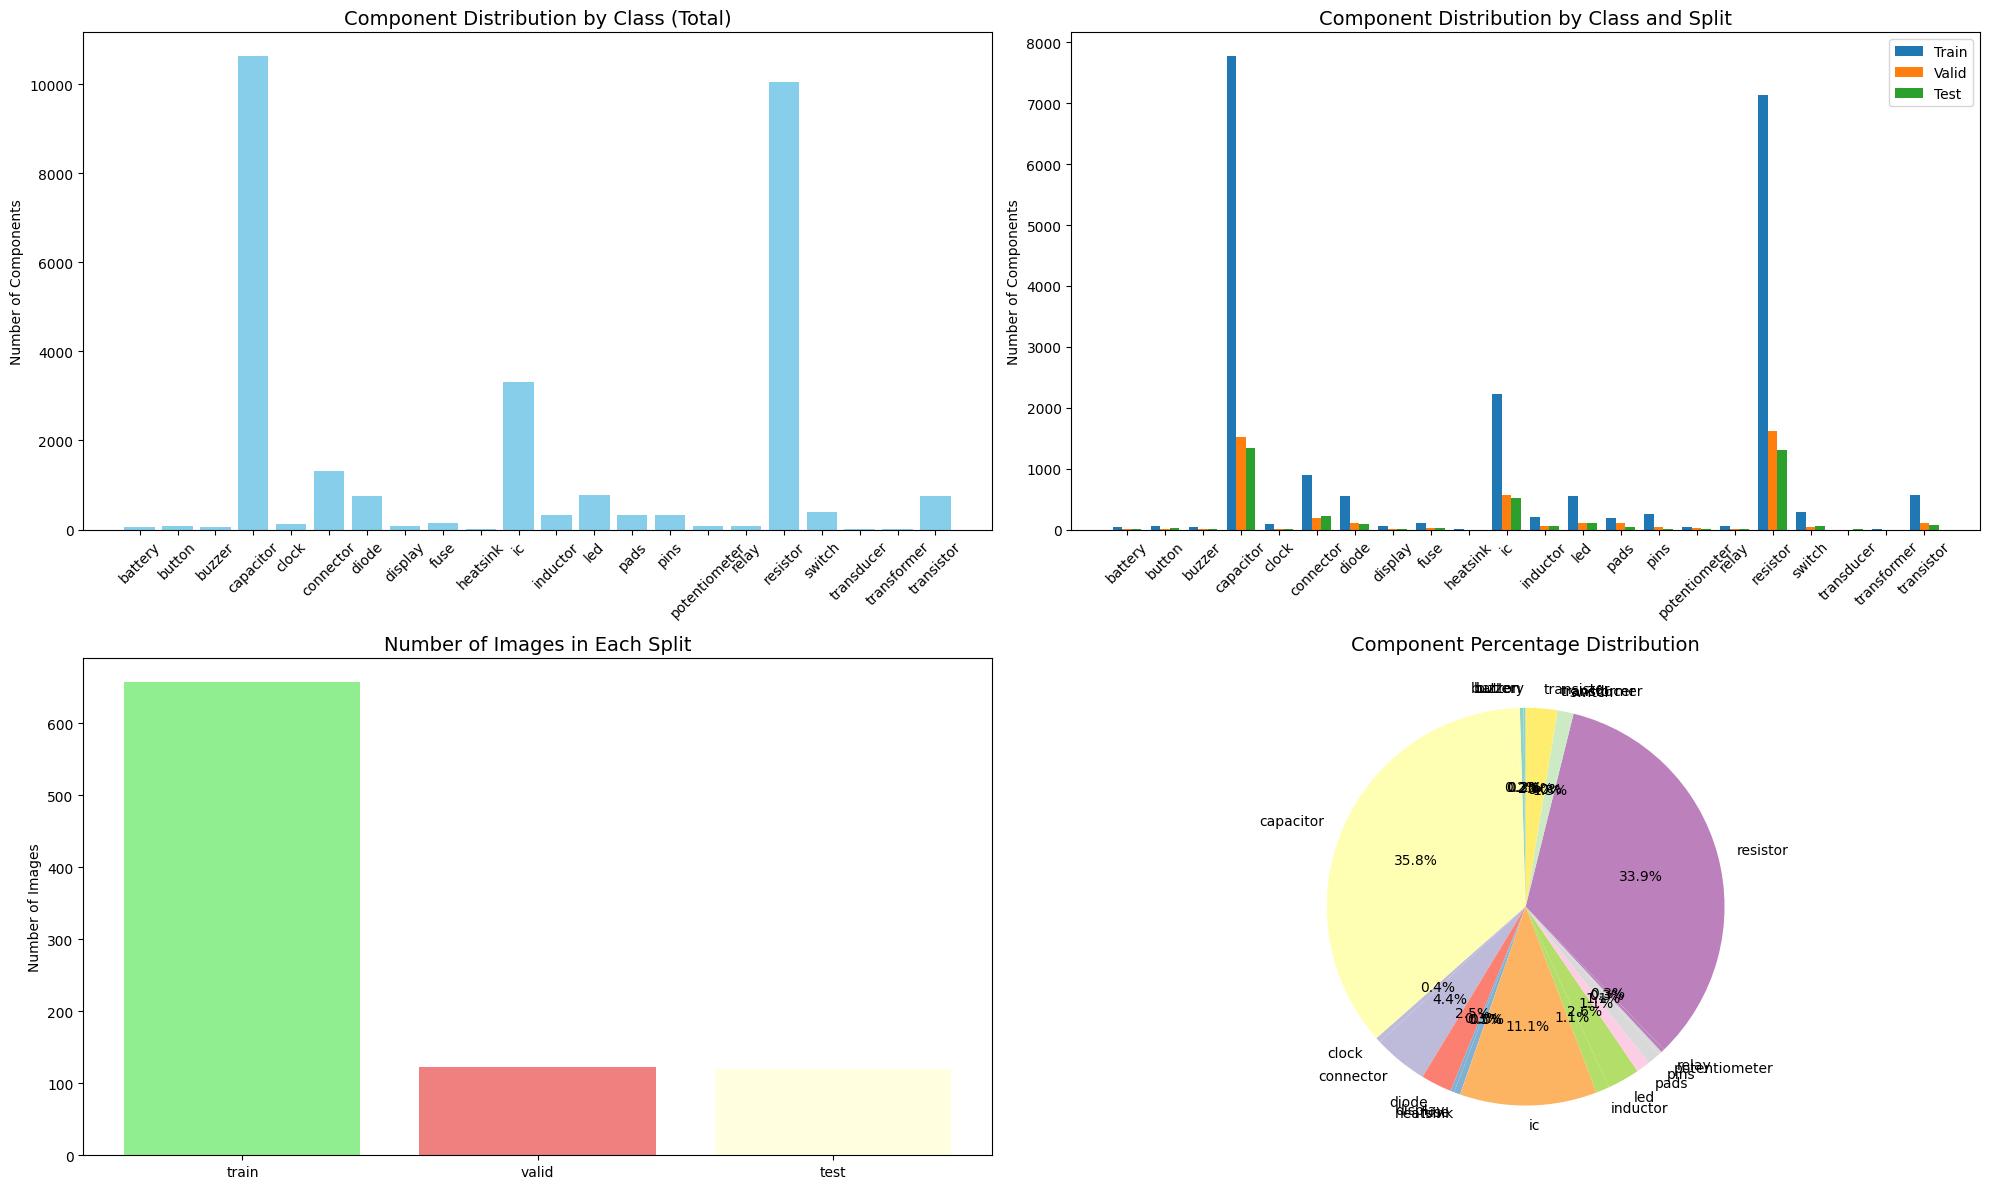


 Additional Statistics
• Train split: 32.17 components/image on average
• Valid split: 37.43 components/image on average
• Test split: 32.82 components/image on average

 Most Common Classes:
   capacitor: 10631 components
   resistor: 10049 components
   ic: 3302 components
   connector: 1311 components
   led: 776 components

 Least Common Classes:
   transformer: 2 components
   transducer: 4 components
   heatsink: 4 components
   battery: 54 components
   buzzer: 60 components


In [3]:
# Component Analysis and Counting in the Dataset


def analyze_components_structure():
    """Analyze the structure and count the components"""

    # Base path for the data
    data_path = "components_data_clean"

    print("=" * 60)
    print("Analysis of Electronic Circuit Component Data Structure")
    print("=" * 60)

    # Read the data.yaml file
    data_yaml_path = os.path.join(data_path, 'data_clean.yaml')
    with open(data_yaml_path, 'r', encoding='utf-8') as f:
        data_config = yaml.safe_load(f)

    print("📁 Folder Structure:")
    print(f"Base Path: {data_path}")

    # Analyze folders and files
    for root, dirs, files in os.walk(data_path):
        level = root.replace(data_path, '').count(os.sep)
        indent = ' ' * 2 * level
        print(f'{indent} {os.path.basename(root)}/')
        sub_indent = ' ' * 2 * (level + 1)
        for file in files:
            print(f'{sub_indent} {file}')

    return data_config, data_path

def count_components_in_split(split_name, data_path):
    """Count components in a specific split (train/valid/test)"""

    labels_path = os.path.join(data_path, split_name, 'labels')
    images_path = os.path.join(data_path, split_name, 'images')

    print(f"\n🔍 Analyzing {split_name} Split:")
    print(f"   Labels Path: {labels_path}")
    print(f"   Images Path: {images_path}")

    if not os.path.exists(labels_path):
        print(f"    Labels folder not found!")
        return {}, 0, 0

    if not os.path.exists(images_path):
        print(f"    Images folder not found!")
        return {}, 0, 0

    # Count image files
    image_files = [f for f in os.listdir(images_path)
                   if f.lower().endswith(('.jpg', '.jpeg', '.png'))]

    # Count components from label files
    component_counter = Counter()
    total_components = 0
    label_files_count = 0

    for label_file in os.listdir(labels_path):
        if label_file.endswith('.txt'):
            label_files_count += 1
            label_file_path = os.path.join(labels_path, label_file)

            try:
                with open(label_file_path, 'r', encoding='utf-8') as f:
                    lines = f.readlines()

                for line in lines:
                    if line.strip():  # Ignore empty lines
                        parts = line.strip().split()
                        if len(parts) >= 5:  # YOLO format: class x_center y_center width height
                            class_id = int(parts[0])
                            component_counter[class_id] += 1
                            total_components += 1

            except Exception as e:
                print(f"   ❌ Error reading file {label_file}: {e}")

    print(f"    Statistics:")
    print(f"     • Number of Images: {len(image_files)}")
    print(f"     • Number of Label Files: {label_files_count}")
    print(f"     • Total Components: {total_components}")
    print(f"     • Number of Distinct Classes: {len(component_counter)}")

    return component_counter, len(image_files), total_components

def analyze_all_components():
    """Analyze all components in the dataset"""

    data_config, data_path = analyze_components_structure()

    print("\n" + "=" * 60)
    print(" Component Counting Across All Splits")
    print("=" * 60)

    splits = ['train', 'valid', 'test']
    all_components = Counter()
    split_stats = {}

    for split in splits:
        components, image_count, total_components = count_components_in_split(split, data_path)
        all_components.update(components)
        split_stats[split] = {
            'components': components,
            'images': image_count,
            'total_components': total_components
        }

    return data_config, split_stats, all_components

def visualize_component_distribution(data_config, split_stats, all_components):
    """Visualize the component distribution"""

    # Get class names
    class_names = data_config.get('names', [])

    print("\n" + "=" * 60)
    print(" Component Distribution by Class")
    print("=" * 60)

    # Display detailed statistics
    total_all_components = sum(all_components.values())

    print(f"\nTotal components across all splits: {total_all_components}")
    print("\nComponent breakdown by class:")
    print("-" * 80)
    print(f"{'Class':<20} {'Total':<10} {'Percent %':<10} {'Train':<10} {'Valid':<10} {'Test':<10}")
    print("-" * 80)

    for class_id in sorted(all_components.keys()):
        class_name = class_names[class_id] if class_id < len(class_names) else f"Class_{class_id}"
        total_count = all_components[class_id]
        percentage = (total_count / total_all_components) * 100

        train_count = split_stats['train']['components'].get(class_id, 0)
        valid_count = split_stats['valid']['components'].get(class_id, 0)
        test_count = split_stats['test']['components'].get(class_id, 0)

        print(f"{class_name:<20} {total_count:<10} {percentage:<10.2f} {train_count:<10} {valid_count:<10} {test_count:<10}")

    # Create charts
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(20, 12))

    # Chart 1: Component Distribution (Total)
    classes = [class_names[i] if i < len(class_names) else f"Class_{i}"
               for i in sorted(all_components.keys())]
    counts = [all_components[i] for i in sorted(all_components.keys())]

    ax1.bar(classes, counts, color='skyblue')
    ax1.set_title('Component Distribution by Class (Total)', fontsize=14)
    ax1.set_ylabel('Number of Components')
    ax1.tick_params(axis='x', rotation=45)

    # Chart 2: Component Distribution by Split
    splits = ['train', 'valid', 'test']
    split_data = {split: [split_stats[split]['components'].get(class_id, 0)
                          for class_id in sorted(all_components.keys())]
                  for split in splits}

    x = np.arange(len(classes))
    width = 0.25

    for i, split in enumerate(splits):
        ax2.bar(x + i * width, split_data[split], width, label=split.capitalize())

    ax2.set_title('Component Distribution by Class and Split', fontsize=14)
    ax2.set_ylabel('Number of Components')
    ax2.set_xticks(x + width)
    ax2.set_xticklabels(classes, rotation=45)
    ax2.legend()

    # Chart 3: Image Distribution
    split_images = [split_stats[split]['images'] for split in splits]
    ax3.bar(splits, split_images, color=['lightgreen', 'lightcoral', 'lightyellow'])
    ax3.set_title('Number of Images in Each Split', fontsize=14)
    ax3.set_ylabel('Number of Images')

    # Chart 4: Component Percentage
    percentages = [(count / total_all_components) * 100 for count in counts]
    colors = plt.cm.Set3(np.linspace(0, 1, len(classes)))
    ax4.pie(percentages, labels=classes, autopct='%1.1f%%', startangle=90, colors=colors)
    ax4.set_title('Component Percentage Distribution', fontsize=14)

    plt.tight_layout()
    plt.show()

    # Additional Statistics
    print("\n" + "=" * 60)
    print(" Additional Statistics")
    print("=" * 60)

    # Average components per image
    for split in splits:
        images_count = split_stats[split]['images']
        components_count = split_stats[split]['total_components']
        if images_count > 0:
            avg_components = components_count / images_count
            print(f"• {split.capitalize()} split: {avg_components:.2f} components/image on average")

    # Most and least common classes
    most_common = all_components.most_common(5)
    least_common = all_components.most_common()[:-6:-1]

    print(f"\n Most Common Classes:")
    for class_id, count in most_common:
        class_name = class_names[class_id] if class_id < len(class_names) else f"Class_{class_id}"
        print(f"   {class_name}: {count} components")

    print(f"\n Least Common Classes:")
    for class_id, count in least_common:
        class_name = class_names[class_id] if class_id < len(class_names) else f"Class_{class_id}"
        print(f"   {class_name}: {count} components")

# Run the analysis
data_config, split_stats, all_components = analyze_all_components()
visualize_component_distribution(data_config, split_stats, all_components)

In [4]:
# Step 3: Define and Verify Class Statistics (with New Numbers)
class_counts = {
    'battery': 84, 'button': 462, 'buzzer': 159, 'capacitor': 11281,
    'clock': 228, 'connector': 2919, 'diode': 711, 'display': 59,
    'fuse': 131, 'ic': 2900, 'inductor': 418, 'led': 1700,
    'pads': 1031, 'pins': 113, 'potentiometer': 155, 'relay': 246,
    'resistor': 11775, 'switch': 467, 'transducer': 4, 'transformer': 45,
    'transistor': 803
}

# Calculate the total and the number of classes
N_total = sum(class_counts.values())
C = len(class_counts)
mean_instances = N_total / C

print("--- PCB Dataset Statistics Verification (Updated) ---")
print(f"Total Instances (Total N): {N_total}")
print(f"Total Number of Classes (C): {C}")
print(f"Mean Instances per Class (Mean): {mean_instances:.2f}")

# Display the most and least common classes for visual verification
print("\nMost Common Classes:")
sorted_counts = sorted(class_counts.items(), key=lambda item: item[1], reverse=True)
for name, count in sorted_counts[:3]:
    print(f"- {name}: {count} instances")

print("\nLeast Common Classes (Focus Area):")
for name, count in sorted_counts[-3:]:
    print(f"- {name}: {count} instances")

--- PCB Dataset Statistics Verification (Updated) ---
Total Instances (Total N): 35691
Total Number of Classes (C): 21
Mean Instances per Class (Mean): 1699.57

Most Common Classes:
- resistor: 11775 instances
- capacitor: 11281 instances
- connector: 2919 instances

Least Common Classes (Focus Area):
- display: 59 instances
- transformer: 45 instances
- transducer: 4 instances


In [5]:
# Step 4: Calculate and Store Class Weights

import torch # PyTorch is required for the final tensor conversion

# Pre-calculated variables (from Step 3):
N_total = 37507
C = 21
mean_instances = N_total / C # 1786.0476...

class_counts = {
    'battery': 84, 'button': 462, 'buzzer': 159, 'capacitor': 11281,
    'clock': 228, 'connector': 2919, 'diode': 711, 'display': 59,
    'fuse': 131, 'ic': 2900, 'inductor': 418, 'led': 1700,
    'pads': 1031, 'pins': 113, 'potentiometer': 155, 'relay': 246,
    'resistor': 11775, 'switch': 467, 'transducer': 4, 'transformer': 45,
    'transistor': 803
}

class_weights = []
# Recalculate mean_instances for precision (optional, but good practice)
mean_instances = N_total / C

# Loop through each class and calculate the weight
for count in class_counts.values():
    # Formula: Weight = Mean_Instances / Instances_in_This_Class
    weight = mean_instances / count
    class_weights.append(weight)

# Convert the list to a tensor for use in PyTorch (required for YOLO)
class_weights_tensor = torch.tensor(class_weights, dtype=torch.float32)

print(f"Calculated {len(class_weights)} class weights.")
print("\nFirst 5 weights: ", class_weights[:5])
print("\nExample Weights (Min/Max):")
print(f"  Max Weight (Transducer, Count=4): {max(class_weights):.4f}")
print(f"  Min Weight (Resistor, Count=11775): {min(class_weights):.4f}")

Calculated 21 class weights.

First 5 weights:  [21.2624716553288, 3.865903937332509, 11.233003893381252, 0.15832351910713757, 7.833542188805347]

Example Weights (Min/Max):
  Max Weight (Transducer, Count=4): 446.5119
  Min Weight (Resistor, Count=11775): 0.1517


In [6]:
# --- 1. Define Paths (Ensure Correctness) ---
# Using r'' for raw strings is good practice for Windows paths
DATASET_PATH = 'components_data_clean/data_clean.yaml'
MODEL_SAVE_DIR = 'model'
# The model will be saved in: model/pcb_detector_v8m/weights/best.pt (path depends on OS)

# --- 2. High-Precision Training Command Optimized for Imbalanced Data ---
print("--- Starting YOLOv8m training optimized for highest precision ---")
# FIX: Added '!' prefix to execute the yolo command in the shell
!yolo train \
model=yolov8m.pt \
data={DATASET_PATH} \
epochs=150 \
imgsz=1024 \
batch=8 \
device=0 \
patience=50 \
weight_decay=0.001 \
hsv_s=0.5 \
shear=2.0 \
degrees=15.0 \
scale=0.8 \
name=pcb_detector_v8m \
project={MODEL_SAVE_DIR}

print("\n--- Training started. The final model will be saved to Drive ---")

--- Starting YOLOv8m training optimized for highest precision ---
^C

--- Training started. The final model will be saved to Drive ---
